## 提取迷宫

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
import sys
import time
import pandas as pd
from tqdm import tqdm

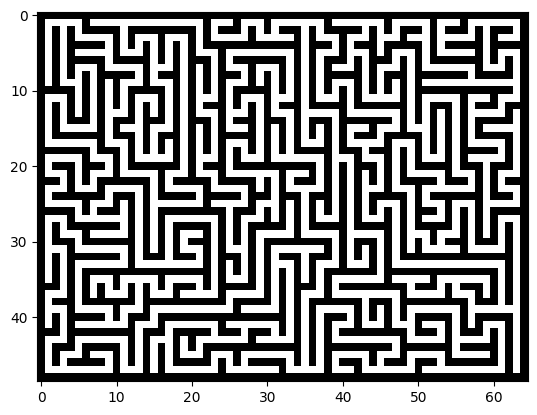

In [2]:
def check_pixel(block):
    if np.max(block) > 200:
        return 0
    else:
        return 1
def read_maze(img_name):
    bound_x_min = 50
    bound_x_max = 570
    bound_y_min = 48
    bound_y_max = 440
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    step = 8
    maze = np.zeros(((bound_y_max-bound_y_min)//step, (bound_x_max-bound_x_min)//step))
    maze.shape
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            maze[i,j] = check_pixel(img_gray[bound_y_min+i*step:bound_y_min+(i+1)*step, bound_x_min+j*step:bound_x_min+(j+1)*step])
    maze[-5,-2] = 1
    maze[-1,-2] = 0
    return maze
maze = read_maze('maze.jpeg')
plt.imshow(maze, cmap='gray')

## Q-learning算法

In [3]:
class Q_learning_table():
    def __init__(self,
                 maze,
                 learning_rate=0.01,
                 exploration_decay=0.9):
        self.actions = list(range(4))
        self.maze = maze
        self.learning_rate = learning_rate
        self.exploration_decay = exploration_decay
        self.q_table = pd.DataFrame(columns=list(range(4)), dtype=np.float32)
        self.init_status()
    
    def init_status(self):
        path_index = np.where(maze == 1)
        path_index_list = []
        for i in range(len(path_index[0])):
            path_index_list.append((path_index[0][i],path_index[1][i]))
        for item in path_index_list:
            up = 0
            down = 0
            left = 0
            right = 0
            if (item[0]-1,item[1]) not in path_index_list:
                up = -1
            if (item[0]+1,item[1]) not in path_index_list:
                down = -1
            if (item[0],item[1]-1) not in path_index_list:
                left = -1
            if (item[0],item[1]+1) not in path_index_list:
                right = -1
            self.q_table.loc[str([item[1],item[0]])] = [up,down,right,left]
        block_index = np.where(maze == 0)
        for i in range(len(block_index[0])):
            self.q_table.loc[str([block_index[1][i],block_index[0][i]])] = [0,0,0,0]
    
    def choose_action(self, s, random):
        s = str(s)
        if np.random.uniform() < random:
            state_action = self.q_table.loc[s, :]
            state_action = state_action.reindex(
                np.random.permutation(
                    state_action.index))  # 防止相同列值时取第一个列，所以打乱列的顺序
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action
    
    def rl(self, s, a, r, s_):
        q_predict = self.q_table.loc[s, a]  # q估计
        if s_ != 'terminal':
            q_target = r + self.exploration_decay * self.q_table.loc[
                s_, :].max()  # q现实
        else:
            q_target = r
        self.q_table.loc[s, a] += self.learning_rate * (q_target - q_predict)
            

In [4]:
from copy import deepcopy
import pickle
class SimulateRun():
    def __init__(self, maze,RL, oval,iter=600, startpoint=[63,44],exploration_greedy=0.999):
        self.maze = maze
        self.oval = oval
        self.iter = iter
        self.startpoint = deepcopy(startpoint)
        self.visit_set = set()
        self.curpoint = deepcopy(startpoint)
        self.nextpoint = deepcopy(startpoint)
        self.RL = RL
        self.exploration_greedy = exploration_greedy
        self.init_status()
        
    def init_status(self):
        self.blocks = []
        block_index = np.where(self.maze == 0)
        for i in range(len(block_index[0])):
            self.blocks.append([block_index[1][i], block_index[0][i]])
    def step(self,action):
        if action == 0:
            self.nextpoint[1] = self.curpoint[1] - 1
        elif action == 1:
            self.nextpoint[1] = self.curpoint[1] + 1
        elif action == 2:
            self.nextpoint[0] = self.curpoint[0] + 1
        elif action == 3:
            self.nextpoint[0] = self.curpoint[0] - 1
        if self.nextpoint in self.blocks:
            self.visit_set = set()
            return -1,True
        elif self.curpoint == self.oval:
            self.visit_set = set()
            return 1,True
        elif str(self.nextpoint) in self.visit_set:
            self.visit_set.add(str(self.nextpoint))
            return -0.1,False
        else:
            self.visit_set.add(str(self.nextpoint))
            return 0,False
    def run(self):
        for i in tqdm(range(self.iter)):
            while True:
                action = self.RL.choose_action(self.curpoint,self.exploration_greedy)
                reward,condition = self.step(action)
                self.RL.rl(str(self.curpoint), action, reward, str(self.nextpoint))
                self.curpoint = deepcopy(self.nextpoint)
                if condition:
                    self.curpoint = deepcopy(self.startpoint)
                    self.nextpoint = deepcopy(self.startpoint)
                    break

In [5]:
# oval = [1,1]
# startpoint = [63,44]
# RL = Q_learning_table(maze=maze)
# SR =  SimulateRun(maze,RL,oval)
# SR.run()
# with open(f'q_learning_table-{startpoint}-{oval}.pkl', 'wb') as pkl_file:
#     pickle.dump(SR, pkl_file)

## 预测

In [6]:
def predict_by_file(file,startpoint,oval):
    with open(file, 'rb') as pkl_file:
        SR = pickle.load(pkl_file)
    print('start_state:{}'.format(startpoint))
    SR.curpoint = startpoint
    step = 0
    path = []
    while True:
            step = step + 1
            action = SR.RL.choose_action(SR.curpoint, 1)
            # 预测阶段，reward用不到了，故使用_代替
            _, condition = SR.step(action)
            # SR.RL.rl(str(SR.curpoint), action, 0, str(SR.nextpoint))
            # 输出动作和下个状态
            print('step:{step}, action: {action}, state: {state}'.format(step=step, action=action, state=SR.curpoint))
            record_point = deepcopy(SR.curpoint)
            record_point.append(action)
            path.append(record_point)
            # 如果done或者步数超过100,游戏结束退出
            if condition or step > 1000:
                if SR.curpoint == oval:
                    print('success')
                else:
                    print('fail')
                break
            # 跳转到下个状态
            else:
                SR.curpoint = deepcopy(SR.nextpoint)
    return path

## 交互

In [7]:
class MazeConstructor(tk.Tk):
    def __init__(self,maze,oval,path,startpoint=[63,44],MAZE_H=49,MAZE_W=65,UNIT=16):
        super(MazeConstructor, self).__init__()
        self.UNIT = UNIT
        self.MAZE_H = MAZE_H
        self.MAZE_W = MAZE_W
        self.maze = maze
        self.oval = oval
        self.path = path
        self.startpoint = startpoint
        self.visit_set = set(str(self.startpoint))
        self.geometry('{0}x{1}'.format(self.MAZE_H * self.UNIT + 300,
                                       self.MAZE_W * self.UNIT))
        self.tk_build_maze()

    def tk_draw_square(self,x,y,c):
        center = self.UNIT / 2
        w = center - 5
        x_ = self.UNIT * x + center
        y_ = self.UNIT * y + center
        return self.canvas.create_rectangle(x_ - w, y_ - w, x_ + w, y_ + w, fill=c)
    
    def tk_create_line(self,x,y,direction,c):
        center = self.UNIT / 2
        w = center - 5 
        if direction == 1: # up
            x1 = x * self.UNIT + center
            y1 = y * self.UNIT + center -w
            x2 = x * self.UNIT + center
            y2 = y * self.UNIT + center + w
        if direction == 0: # down
            x1 = x * self.UNIT + center 
            y1 = y * self.UNIT + center + w
            x2 = x * self.UNIT + center  
            y2 = y * self.UNIT + center - w
        if direction == 2: # left
            x1 = x * self.UNIT + center - w
            y1 = y * self.UNIT + center
            x2 = x * self.UNIT + center + w
            y2 = y * self.UNIT + center
        if direction == 3: # right
            x1 = x * self.UNIT + center + w
            y1 = y * self.UNIT + center
            x2 = x * self.UNIT + center - w
            y2 = y * self.UNIT + center
        return self.canvas.create_line(x1,y1,x2,y2,width=2,arrow=tk.LAST,fill=c)


    def tk_build_maze(self):
        h = self.MAZE_H * self.UNIT
        w = self.MAZE_W * self.UNIT
        # 初始化画布
        self.canvas = tk.Canvas(self, bg='white', height=h, width=w)
        self.textcanvas = tk.Canvas(self, bg='white', height=h, width=w)
        # 画线
        for c in range(0, w, self.UNIT):
            self.canvas.create_line(c, 0, c, h)
        for r in range(0, h, self.UNIT):
            self.canvas.create_line(0, r, w, r)

        # 陷阱
        self.hells = []
        block_index = np.where(self.maze == 0)
        for i in range(len(block_index[0])):
            self.hells.append(self.tk_draw_square(block_index[1][i], block_index[0][i], 'black'))
        self.hell_coords = []
        for hell in self.hells:
            self.hell_coords.append(self.canvas.coords(hell))
        
        # 奖励
        if self.oval!=[]:
            self.oval = self.tk_draw_square(*self.oval, 'red')

        # 路径
        self.path = [self.tk_create_line(*p, 'orange') for p in self.path]
        # 玩家对象
        self.rect = self.tk_draw_square( *self.startpoint, 'yellow')
        self.textfield = self.textcanvas.create_text(w//2,100,text='请点击图上任意白点，开始进行路径规划，这需要一点时间！')
        self.canvas.pack()  #执行画
        self.textcanvas.pack()
    
    def reset(self,oval,path,startpoint=[63,44]):
        self.canvas.delete("all")
        self.oval = deepcopy(oval)
        self.path = deepcopy(path)
        self.startpoint = startpoint
        h = self.MAZE_H * self.UNIT
        w = self.MAZE_W * self.UNIT
        # 初始化画布
        # self.canvas = tk.Canvas(self, bg='white', height=h, width=w)
        # 画线
        for c in range(0, w, self.UNIT):
            self.canvas.create_line(c, 0, c, h)
        for r in range(0, h, self.UNIT):
            self.canvas.create_line(0, r, w, r)
        self.hells = []
        block_index = np.where(self.maze == 0)
        for i in range(len(block_index[0])):
            self.hells.append(self.tk_draw_square(block_index[1][i], block_index[0][i], 'black'))
        self.hell_coords = []
        for hell in self.hells:
            self.hell_coords.append(self.canvas.coords(hell))

        # 奖励
        self.oval = self.tk_draw_square(*self.oval, 'red')
        self.rect = self.tk_draw_square( *self.startpoint, 'yellow')

        # 路径
        self.path = [self.tk_create_line(*p, 'orange') for p in self.path[1:-1]]
        if self.path != []:
            if path[-1][:2] == oval:
                self.textcanvas.itemconfigure(self.textfield,text=f'能够在{len(self.path)}步后到达目的地!')
            else:
                self.textcanvas.itemconfigure(self.textfield,text=f'不能到达目的地!')
        self.update()
        